In [1]:
# begin by implementing the simple model provided by the author
# copying from https://github.com/Eligijus112/word-embedding-creation/

import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm

# Drawing the embeddings
import matplotlib.pyplot as plt

In [2]:
# Deep learning: more dependencies
# luckily all the required packages were already installed in my mlenv anaconda environment used in class

from keras.models import Input, Model
from keras.layers import Dense

from scipy import sparse

# Custom functions- my own version saved in my local folder
from utils import text_preprocessing, create_unique_word_dict, clean_text

Using TensorFlow backend.


In [3]:
# here is where the real code begins 

# Defining the window for context
window = 2

# Reading the text from the input folder
texts = pd.read_csv('input/sample.csv')
# restore later after I play around with manually introducing new text
texts = [x for x in texts['text']]

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])
                
unique_word_dict = create_unique_word_dict(all_text)

# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

# Creating the X and Y matrices using one hot encoding
X = []
Y = []

In [4]:
# for simplicity and debugging I am splitting up the code into cells that can be run individually
for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)


84it [00:00, 41948.03it/s]


In [5]:
# lets inspect the contents of the variables before moving to the next steps 
# looks like the X variable has 1355 data points

print(X,Y)

  (0, 6)	1.0
  (1, 6)	1.0
  (2, 7)	1.0
  (3, 7)	1.0
  (4, 11)	1.0
  (5, 11)	1.0
  (6, 4)	1.0
  (7, 12)	1.0
  (8, 17)	1.0
  (9, 11)	1.0
  (10, 10)	1.0
  (11, 10)	1.0
  (12, 8)	1.0
  (13, 8)	1.0
  (14, 8)	1.0
  (15, 2)	1.0
  (16, 2)	1.0
  (17, 2)	1.0
  (18, 7)	1.0
  (19, 7)	1.0
  (20, 10)	1.0
  (21, 10)	1.0
  (22, 20)	1.0
  (23, 20)	1.0
  (24, 20)	1.0
  :	:
  (59, 7)	1.0
  (60, 7)	1.0
  (61, 7)	1.0
  (62, 7)	1.0
  (63, 13)	1.0
  (64, 13)	1.0
  (65, 13)	1.0
  (66, 13)	1.0
  (67, 19)	1.0
  (68, 19)	1.0
  (69, 19)	1.0
  (70, 3)	1.0
  (71, 3)	1.0
  (72, 11)	1.0
  (73, 11)	1.0
  (74, 10)	1.0
  (75, 10)	1.0
  (76, 10)	1.0
  (77, 1)	1.0
  (78, 1)	1.0
  (79, 1)	1.0
  (80, 9)	1.0
  (81, 9)	1.0
  (82, 1)	1.0
  (83, 8)	1.0   (0, 7)	1.0
  (1, 11)	1.0
  (2, 11)	1.0
  (3, 6)	1.0
  (4, 7)	1.0
  (5, 6)	1.0
  (6, 12)	1.0
  (7, 4)	1.0
  (8, 11)	1.0
  (9, 17)	1.0
  (10, 8)	1.0
  (11, 2)	1.0
  (12, 2)	1.0
  (13, 10)	1.0
  (14, 7)	1.0
  (15, 7)	1.0
  (16, 8)	1.0
  (17, 10)	1.0
  (18, 2)	1.0
  (19, 8)	1.0
  (

In [6]:
# here is the next chunk of code to make sure it runs 
# we get an error from the model.fit so lets walk it through 1 line at a time

# STOP HERE FOR NOW UNTIL I COMPLETE MORE TROUBLESHOOTING 

# Defining the size of the embedding
embed_size = 2

# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')



In [7]:
# Optimizing the network weights
model.fit(
    x=X, 
    y=Y, 
    batch_size=256,
    epochs=1000
    )

Epoch 1/1000
84/84 [==============================] - 0s 6ms/step - loss: 3.0352
Epoch 2/1000
84/84 [==============================] - 0s 107us/step - loss: 3.0340
Epoch 3/1000
84/84 [==============================] - 0s 119us/step - loss: 3.0330
Epoch 4/1000
84/84 [==============================] - 0s 178us/step - loss: 3.0319
Epoch 5/1000
84/84 [==============================] - 0s 262us/step - loss: 3.0308
Epoch 6/1000
84/84 [==============================] - 0s 131us/step - loss: 3.0296
Epoch 7/1000
84/84 [==============================] - 0s 131us/step - loss: 3.0285
Epoch 8/1000
84/84 [==============================] - 0s 131us/step - loss: 3.0273
Epoch 9/1000
84/84 [==============================] - 0s 119us/step - loss: 3.0262
Epoch 10/1000
84/84 [==============================] - 0s 178us/step - loss: 3.0250
Epoch 11/1000
84/84 [==============================] - 0s 214us/step - loss: 3.0238
Epoch 12/1000
84/84 [==============================] - 0s 119us/step - loss: 3.0227
Epo

Epoch 99/1000
84/84 [==============================] - 0s 202us/step - loss: 2.9273
Epoch 100/1000
84/84 [==============================] - 0s 143us/step - loss: 2.9262
Epoch 101/1000
84/84 [==============================] - 0s 178us/step - loss: 2.9251
Epoch 102/1000
84/84 [==============================] - 0s 107us/step - loss: 2.9241
Epoch 103/1000
84/84 [==============================] - 0s 178us/step - loss: 2.9230
Epoch 104/1000
84/84 [==============================] - 0s 107us/step - loss: 2.9220
Epoch 105/1000
84/84 [==============================] - 0s 107us/step - loss: 2.9209
Epoch 106/1000
84/84 [==============================] - 0s 119us/step - loss: 2.9198
Epoch 107/1000
84/84 [==============================] - 0s 107us/step - loss: 2.9188
Epoch 108/1000
84/84 [==============================] - 0s 155us/step - loss: 2.9177
Epoch 109/1000
84/84 [==============================] - 0s 167us/step - loss: 2.9167
Epoch 110/1000
84/84 [==============================] - 0s 214us/s

Epoch 196/1000
84/84 [==============================] - 0s 178us/step - loss: 2.8250
Epoch 197/1000
84/84 [==============================] - 0s 107us/step - loss: 2.8239
Epoch 198/1000
84/84 [==============================] - 0s 119us/step - loss: 2.8229
Epoch 199/1000
84/84 [==============================] - 0s 95us/step - loss: 2.8219
Epoch 200/1000
84/84 [==============================] - 0s 547us/step - loss: 2.8208
Epoch 201/1000
84/84 [==============================] - 0s 107us/step - loss: 2.8198
Epoch 202/1000
84/84 [==============================] - 0s 95us/step - loss: 2.8188
Epoch 203/1000
84/84 [==============================] - 0s 155us/step - loss: 2.8177
Epoch 204/1000
84/84 [==============================] - 0s 286us/step - loss: 2.8167
Epoch 205/1000
84/84 [==============================] - 0s 155us/step - loss: 2.8156
Epoch 206/1000
84/84 [==============================] - 0s 107us/step - loss: 2.8146
Epoch 207/1000
84/84 [==============================] - 0s 178us/st

Epoch 293/1000
84/84 [==============================] - 0s 202us/step - loss: 2.7265
Epoch 294/1000
84/84 [==============================] - 0s 167us/step - loss: 2.7255
Epoch 295/1000
84/84 [==============================] - 0s 95us/step - loss: 2.7245
Epoch 296/1000
84/84 [==============================] - 0s 95us/step - loss: 2.7235
Epoch 297/1000
84/84 [==============================] - 0s 274us/step - loss: 2.7225
Epoch 298/1000
84/84 [==============================] - 0s 107us/step - loss: 2.7215
Epoch 299/1000
84/84 [==============================] - 0s 119us/step - loss: 2.7205
Epoch 300/1000
84/84 [==============================] - 0s 155us/step - loss: 2.7195
Epoch 301/1000
84/84 [==============================] - 0s 274us/step - loss: 2.7185
Epoch 302/1000
84/84 [==============================] - 0s 119us/step - loss: 2.7175
Epoch 303/1000
84/84 [==============================] - 0s 107us/step - loss: 2.7165
Epoch 304/1000
84/84 [==============================] - 0s 119us/st

Epoch 390/1000
84/84 [==============================] - 0s 178us/step - loss: 2.6326
Epoch 391/1000
84/84 [==============================] - 0s 309us/step - loss: 2.6317
Epoch 392/1000
84/84 [==============================] - 0s 107us/step - loss: 2.6307
Epoch 393/1000
84/84 [==============================] - 0s 95us/step - loss: 2.6298
Epoch 394/1000
84/84 [==============================] - 0s 119us/step - loss: 2.6289
Epoch 395/1000
84/84 [==============================] - 0s 226us/step - loss: 2.6280
Epoch 396/1000
84/84 [==============================] - 0s 131us/step - loss: 2.6270
Epoch 397/1000
84/84 [==============================] - 0s 131us/step - loss: 2.6261
Epoch 398/1000
84/84 [==============================] - 0s 143us/step - loss: 2.6252
Epoch 399/1000
84/84 [==============================] - 0s 131us/step - loss: 2.6243
Epoch 400/1000
84/84 [==============================] - 0s 95us/step - loss: 2.6234
Epoch 401/1000
84/84 [==============================] - 0s 119us/st

Epoch 487/1000
84/84 [==============================] - 0s 107us/step - loss: 2.5495
Epoch 488/1000
84/84 [==============================] - 0s 119us/step - loss: 2.5487
Epoch 489/1000
84/84 [==============================] - 0s 95us/step - loss: 2.5479
Epoch 490/1000
84/84 [==============================] - 0s 333us/step - loss: 2.5471
Epoch 491/1000
84/84 [==============================] - 0s 95us/step - loss: 2.5464
Epoch 492/1000
84/84 [==============================] - 0s 107us/step - loss: 2.5456
Epoch 493/1000
84/84 [==============================] - 0s 95us/step - loss: 2.5448
Epoch 494/1000
84/84 [==============================] - 0s 131us/step - loss: 2.5441
Epoch 495/1000
84/84 [==============================] - 0s 131us/step - loss: 2.5433
Epoch 496/1000
84/84 [==============================] - 0s 119us/step - loss: 2.5425
Epoch 497/1000
84/84 [==============================] - 0s 226us/step - loss: 2.5418
Epoch 498/1000
84/84 [==============================] - 0s 155us/ste

Epoch 584/1000
84/84 [==============================] - 0s 131us/step - loss: 2.4820
Epoch 585/1000
84/84 [==============================] - 0s 131us/step - loss: 2.4813
Epoch 586/1000
84/84 [==============================] - 0s 155us/step - loss: 2.4807
Epoch 587/1000
84/84 [==============================] - 0s 95us/step - loss: 2.4801
Epoch 588/1000
84/84 [==============================] - 0s 95us/step - loss: 2.4795
Epoch 589/1000
84/84 [==============================] - 0s 95us/step - loss: 2.4789
Epoch 590/1000
84/84 [==============================] - 0s 464us/step - loss: 2.4783
Epoch 591/1000
84/84 [==============================] - 0s 119us/step - loss: 2.4776
Epoch 592/1000
84/84 [==============================] - 0s 619us/step - loss: 2.4770
Epoch 593/1000
84/84 [==============================] - 0s 107us/step - loss: 2.4764
Epoch 594/1000
84/84 [==============================] - 0s 107us/step - loss: 2.4758
Epoch 595/1000
84/84 [==============================] - 0s 190us/ste

Epoch 681/1000
84/84 [==============================] - 0s 119us/step - loss: 2.4280
Epoch 682/1000
84/84 [==============================] - 0s 107us/step - loss: 2.4275
Epoch 683/1000
84/84 [==============================] - 0s 155us/step - loss: 2.4270
Epoch 684/1000
84/84 [==============================] - 0s 95us/step - loss: 2.4265
Epoch 685/1000
84/84 [==============================] - 0s 119us/step - loss: 2.4261
Epoch 686/1000
84/84 [==============================] - 0s 131us/step - loss: 2.4256
Epoch 687/1000
84/84 [==============================] - 0s 250us/step - loss: 2.4251
Epoch 688/1000
84/84 [==============================] - 0s 119us/step - loss: 2.4246
Epoch 689/1000
84/84 [==============================] - 0s 131us/step - loss: 2.4241
Epoch 690/1000
84/84 [==============================] - 0s 107us/step - loss: 2.4236
Epoch 691/1000
84/84 [==============================] - 0s 155us/step - loss: 2.4231
Epoch 692/1000
84/84 [==============================] - 0s 119us/s

Epoch 778/1000
84/84 [==============================] - 0s 190us/step - loss: 2.3848
Epoch 779/1000
84/84 [==============================] - 0s 107us/step - loss: 2.3844
Epoch 780/1000
84/84 [==============================] - 0s 167us/step - loss: 2.3840
Epoch 781/1000
84/84 [==============================] - 0s 107us/step - loss: 2.3836
Epoch 782/1000
84/84 [==============================] - 0s 297us/step - loss: 2.3832
Epoch 783/1000
84/84 [==============================] - 0s 107us/step - loss: 2.3828
Epoch 784/1000
84/84 [==============================] - 0s 107us/step - loss: 2.3824
Epoch 785/1000
84/84 [==============================] - 0s 119us/step - loss: 2.3820
Epoch 786/1000
84/84 [==============================] - 0s 559us/step - loss: 2.3816
Epoch 787/1000
84/84 [==============================] - 0s 119us/step - loss: 2.3812
Epoch 788/1000
84/84 [==============================] - 0s 131us/step - loss: 2.3808
Epoch 789/1000
84/84 [==============================] - 0s 143us/

Epoch 875/1000
84/84 [==============================] - 0s 131us/step - loss: 2.3499
Epoch 876/1000
84/84 [==============================] - 0s 357us/step - loss: 2.3496
Epoch 877/1000
84/84 [==============================] - 0s 95us/step - loss: 2.3493
Epoch 878/1000
84/84 [==============================] - 0s 95us/step - loss: 2.3489
Epoch 879/1000
84/84 [==============================] - 0s 107us/step - loss: 2.3486
Epoch 880/1000
84/84 [==============================] - 0s 297us/step - loss: 2.3483
Epoch 881/1000
84/84 [==============================] - 0s 119us/step - loss: 2.3480
Epoch 882/1000
84/84 [==============================] - 0s 119us/step - loss: 2.3477
Epoch 883/1000
84/84 [==============================] - 0s 107us/step - loss: 2.3473
Epoch 884/1000
84/84 [==============================] - 0s 95us/step - loss: 2.3470
Epoch 885/1000
84/84 [==============================] - 0s 107us/step - loss: 2.3467
Epoch 886/1000
84/84 [==============================] - 0s 95us/step

Epoch 972/1000
84/84 [==============================] - 0s 131us/step - loss: 2.3215
Epoch 973/1000
84/84 [==============================] - 0s 107us/step - loss: 2.3213
Epoch 974/1000
84/84 [==============================] - 0s 262us/step - loss: 2.3210
Epoch 975/1000
84/84 [==============================] - 0s 131us/step - loss: 2.3208
Epoch 976/1000
84/84 [==============================] - 0s 119us/step - loss: 2.3205
Epoch 977/1000
84/84 [==============================] - 0s 119us/step - loss: 2.3202
Epoch 978/1000
84/84 [==============================] - 0s 214us/step - loss: 2.3200
Epoch 979/1000
84/84 [==============================] - 0s 119us/step - loss: 2.3197
Epoch 980/1000
84/84 [==============================] - 0s 119us/step - loss: 2.3194
Epoch 981/1000
84/84 [==============================] - 0s 107us/step - loss: 2.3192
Epoch 982/1000
84/84 [==============================] - 0s 107us/step - loss: 2.3189
Epoch 983/1000
84/84 [==============================] - 0s 131us/

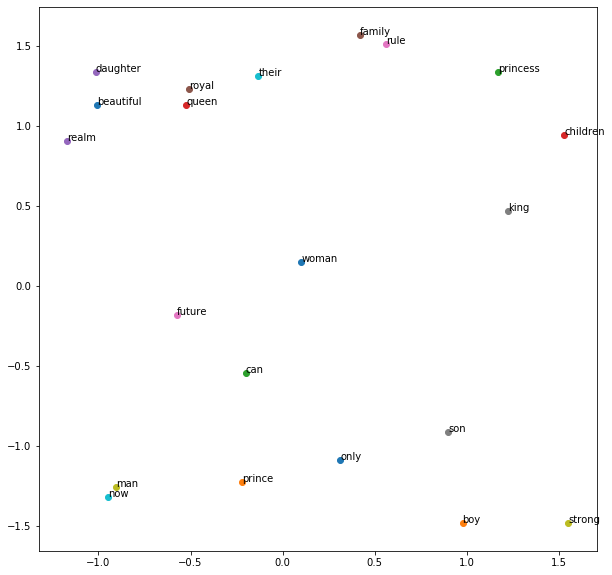

In [8]:
# we get an error here so maybe its the version of keras or maybe something did not install?
# I am going to go back to using the provided sample.csv to train the model see if that has better luck
# version of tensorflow required should be 4.43.0 but my mlenv environment has version 4.59.0 - could that be the reason?



# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))       

# Saving the embedding vector to a txt file
try:
    os.mkdir(f'{os.getcwd()}\\output')        
except Exception as e:
    print(f'Cannot create output folder: {e}')

with open(f'{os.getcwd()}\\output\\embedding.txt', 'w') as f:
    for key, value in embedding_dict.items():
        try:
            f.write(f'{key}: {value}\n')   
        except Exception as e:
            print(f'Cannot write word {key} to dict: {e}')   